### Attention Studies
Objective: How does the current model's attention mechanism create connections between accelerometer reading values within a specific lookback window

Steps: 
1. Extract 5 examples per activity given the lookback window of 1024
2. create a script to go through each window sample within the provided activity window
3. save attention maps of the specific example through inference
4. each index of the window will correspond to a specific column in the attention map
5. highlight this column in the attention map

In [3]:
# Import Libs
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import gzip
from capture24.patch_tst import PatchTST
import yaml

In [4]:
MODEL_PATH = 'capture24/pl32_s32_lr0.001_do0.2_L5_optadamw_h8_wd0p03/'
CONFIG_PATH = 'capture24/pl32_s32_lr0.001_do0.2_L5_optadamw_h8_wd0p03/config.yaml'
TEST_DATA_PATH = 'capture24/final_data_2048/'


In [5]:
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

config['hook_attention_maps'] = True
model = PatchTST(config)
model.load_state_dict(torch.load(MODEL_PATH + 'patchtst_model.pth', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
# Load the Test Data 
with gzip.open(f'{TEST_DATA_PATH}/X_test.npy.gz', 'rb') as f:
    X_test = np.load(f)

with gzip.open(f'{TEST_DATA_PATH}/Y_test.npy.gz', 'rb') as f:
    Y_test = np.load(f)

with open(f'{TEST_DATA_PATH}/label_to_index.json', 'r') as f:
    data = json.load(f)

idx_to_label = data['index_to_label']
label_to_idx = data['label_to_index']

In [7]:
def plot_example(test_example, label, path = None):
    # size will be (512, 3) -> (time, channels)
    # conver to pandas dataframe
    df = pd.DataFrame(
        {
            'time': range(test_example.shape[0]),
            'channel_1': test_example[:, 0],
            'channel_2': test_example[:, 1],
            'channel_3': test_example[:, 2]
        }
    )
    # plot the dataframe
    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'time', y = 'channel_1', data = df)
    sns.lineplot(x = 'time', y = 'channel_2', data = df)
    sns.lineplot(x = 'time', y = 'channel_3', data = df)
    plt.title(f'Test Example for {label}')
    if path: 
        plt.savefig(path)
    plt.show()
    

In [8]:
CLASS_NAMES = list(label_to_idx.keys())
print(CLASS_NAMES)

['bicycling', 'household-chores', 'manual-work', 'mixed-activity', 'sitting', 'sleep', 'sports', 'standing', 'vehicle', 'walking']


## Patch Attention Analysis

**Objective**: Visualize how patches within a sample attend to each other.

**Test Phase**: Starting with ONE example to verify the visualization works correctly before scaling to multiple examples per class.

The visualization will show:
1. **Top**: Full attention heatmap with the query patch highlighted (red dashed line)
2. **Bottom**: The original signal with patches colored by attention weight (red intensity = higher attention) and the query patch highlighted in blue

In [15]:
# =============================================
# CONFIGURATION - Select class and parameters
# =============================================
print("Available classes:", CLASS_NAMES)

# Select the class to analyze
SELECTED_CLASS = CLASS_NAMES[1]  # Change this to select different class
print(f"\nSelected class: {SELECTED_CLASS}")

# Get all indices for the selected class
class_idx = label_to_idx[SELECTED_CLASS]
class_indices = np.where(Y_test == int(class_idx))[0]
print(f"Number of examples for '{SELECTED_CLASS}': {len(class_indices)}")

Available classes: ['bicycling', 'household-chores', 'manual-work', 'mixed-activity', 'sitting', 'sleep', 'sports', 'standing', 'vehicle', 'walking']

Selected class: household-chores
Number of examples for 'household-chores': 11684


In [16]:
# Get patch parameters from the model config
patch_length = config['patch_length']
stride = config['stride']
lookback_window = X_test.shape[1]  # Get actual window size from data

# Calculate number of patches
num_patches = ((lookback_window - patch_length) // stride) + 2  # +2 accounts for padding logic

print(f"Patch Length: {patch_length}")
print(f"Stride: {stride}")
print(f"Lookback Window: {lookback_window}")
print(f"Number of Patches: {num_patches}")

Patch Length: 32
Stride: 32
Lookback Window: 2048
Number of Patches: 65


In [19]:
# =============================================
# TEST WITH ONE EXAMPLE FIRST
# =============================================

# Select one example from the beginning of the class
example_idx = class_indices[0]  # First example
test_example = X_test[example_idx]
test_label = idx_to_label[str(int(Y_test[example_idx]))]

print(f"Selected example index: {example_idx}")
print(f"Example shape: {test_example.shape}")
print(f"Label: {test_label}")

# Run inference to get attention maps
model.eval()
model.attention_maps = []  # Clear previous attention maps
print(model)

with torch.no_grad():
    x_tensor = torch.from_numpy(test_example).float().unsqueeze(0)  # Add batch dimension
    output = model(x_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    
print(f"Predicted class: {idx_to_label[str(pred_class)]}")
print(f"Number of attention map layers captured: {len(model.attention_maps)}")
if len(model.attention_maps) > 0:
    print(f"Attention map shape per layer: {model.attention_maps[0].shape}")

Selected example index: 820
Example shape: (2048, 3)
Label: household-chores
PatchTST(
  (inst_norm): InstanceNorm1d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (patching_layer): PatchingLayer()
  (flatten1): Flatten(start_dim=0, end_dim=1)
  (linear1): Linear(in_features=32, out_features=128, bias=True)
  (pos_encoding): FixedPositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x CustomEncoder(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=Fal

In [20]:
def get_patch_boundaries(num_patches, patch_length, stride, lookback_window):
    """Calculate the start and end indices for each patch in the original signal."""
    boundaries = []
    for i in range(num_patches):
        start = i * stride
        end = start + patch_length
        # Clip to actual window size
        end = min(end, lookback_window)
        boundaries.append((start, end))
    return boundaries

def visualize_patch_attention(test_example, attention_maps, patch_idx, 
                               patch_length, stride, lookback_window,
                               label, layer_idx=0, channel_idx=None):
    """
    Visualize attention for a specific patch.
    
    Args:
        test_example: The input signal (time, channels)
        attention_maps: List of attention maps from each layer
        patch_idx: Which patch to analyze (the "query" patch)
        patch_length: Length of each patch
        stride: Stride between patches
        lookback_window: Total signal length
        label: Class label for title
        layer_idx: Which transformer layer to visualize
        channel_idx: Which channel to show (0=X, 1=Y, 2=Z, None=average all)
    """
    # Get attention map for the specified layer
    # Shape: [num_channels, num_patches, num_patches] (heads already averaged due to CustomEncoder)
    attn = attention_maps[layer_idx].numpy()
    print(f"Raw attention shape: {attn.shape}")
    
    # Handle channel dimension
    # Shape is [channels, num_patches, num_patches] due to channel independence
    if channel_idx is not None:
        attn = attn[channel_idx]  # Select specific channel [num_patches, num_patches]
        channel_label = f"Channel {['X', 'Y', 'Z'][channel_idx]}"
    else:
        attn = attn.mean(axis=0)  # Average over channels [num_patches, num_patches]
        channel_label = "All Channels (avg)"
    
    print(f"Processed attention shape: {attn.shape}")
    num_patches = attn.shape[0]
    patch_boundaries = get_patch_boundaries(num_patches, patch_length, stride, lookback_window)
    
    # Get attention weights FROM the selected patch (row = query)
    attention_from_patch = attn[patch_idx, :]  # What this patch attends to
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [1, 1.5]})
    
    # ===== TOP: Attention Heatmap =====
    ax1 = axes[0]
    im = ax1.imshow(attn, cmap='viridis', aspect='auto')
    ax1.axhline(y=patch_idx, color='red', linewidth=2, linestyle='--', label=f'Query Patch {patch_idx}')
    ax1.axvline(x=patch_idx, color='red', linewidth=2, linestyle='--')
    ax1.set_xlabel('Key Patch Index')
    ax1.set_ylabel('Query Patch Index')
    ax1.set_title(f'Attention Map - Layer {layer_idx}, {channel_label}\n(Red line = Patch {patch_idx})')
    plt.colorbar(im, ax=ax1, label='Attention Weight')
    ax1.legend(loc='upper right')
    
    # ===== BOTTOM: Signal with Highlighted Patches =====
    ax2 = axes[1]
    time = np.arange(test_example.shape[0])
    
    # Plot the 3 channels
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    channel_names = ['X', 'Y', 'Z']
    for ch in range(3):
        ax2.plot(time, test_example[:, ch], color=colors[ch], alpha=0.8, label=f'Channel {channel_names[ch]}')
    
    # Highlight patches based on attention weights
    # Normalize attention for coloring
    attn_normalized = (attention_from_patch - attention_from_patch.min()) / (attention_from_patch.max() - attention_from_patch.min() + 1e-8)
    
    # Color patches by attention weight
    cmap = plt.cm.Reds
    for i, (start, end) in enumerate(patch_boundaries):
        if end <= lookback_window:
            alpha = 0.1 + 0.5 * attn_normalized[i]  # Scale alpha by attention
            color = cmap(attn_normalized[i])
            ax2.axvspan(start, end, alpha=alpha, color=color, linewidth=0)
    
    # Highlight the query patch with a distinct border
    query_start, query_end = patch_boundaries[patch_idx]
    ax2.axvspan(query_start, query_end, alpha=0.3, color='blue', linewidth=0, label=f'Query Patch {patch_idx}')
    ax2.axvline(query_start, color='blue', linewidth=2, linestyle='-')
    ax2.axvline(query_end, color='blue', linewidth=2, linestyle='-')
    
    ax2.set_xlabel('Time Index')
    ax2.set_ylabel('Acceleration')
    ax2.set_title(f'Signal with Attention-Weighted Patches\nClass: {label} | Query Patch {patch_idx} (blue) attends to patches (red intensity = attention weight)')
    ax2.legend(loc='upper right')
    ax2.set_xlim(0, lookback_window)
    
    plt.tight_layout()
    plt.show()
    
    # Print top attended patches
    top_k = 5
    top_indices = np.argsort(attention_from_patch)[::-1][:top_k]
    print(f"\nTop {top_k} patches that Patch {patch_idx} attends to:")
    for rank, idx in enumerate(top_indices):
        start, end = patch_boundaries[idx]
        print(f"  {rank+1}. Patch {idx} (time {start}-{end}): attention = {attention_from_patch[idx]:.4f}")


def visualize_all_layers_attention(test_example, attention_maps, patch_idx, 
                                    patch_length, stride, lookback_window,
                                    label, channel_idx=None, use_stride_segments=False):
    """
    Visualize attention for a specific patch across ALL layers.
    Same format as visualize_patch_attention but expanded for all layers.
    
    Args:
        test_example: The input signal (time, channels)
        attention_maps: List of attention maps from each layer
        patch_idx: Which patch to analyze (the "query" patch)
        patch_length: Length of each patch
        stride: Stride between patches
        lookback_window: Total signal length
        label: Class label for title
        channel_idx: Which channel to show (0=X, 1=Y, 2=Z, None=average all)
        use_stride_segments: If True, show non-overlapping stride-sized segments.
                            If False (default), show full patch extent (overlapping).
    
    For each layer shows:
        - Full attention heatmap with query patch highlighted (red lines)
        - Time series with attention-weighted patches (red) and query patch (blue)
    """
    num_layers = len(attention_maps)
    
    # Calculate patch info from first layer
    attn_sample = attention_maps[0].numpy()
    if channel_idx is not None:
        attn_sample = attn_sample[channel_idx]
    else:
        attn_sample = attn_sample.mean(axis=0)
    num_patches = attn_sample.shape[0]
    patch_boundaries = get_patch_boundaries(num_patches, patch_length, stride, lookback_window)
    
    # Channel label for title
    if channel_idx is not None:
        channel_label = f"Channel {['X', 'Y', 'Z'][channel_idx]}"
    else:
        channel_label = "All Channels (avg)"
    
    # Segment mode label
    segment_mode = "Stride Segments (non-overlapping)" if use_stride_segments else "Full Patch Extent (overlapping)"
    
    # Create figure: 2 rows per layer (attention heatmap + time series)
    fig, axes = plt.subplots(num_layers * 2, 1, figsize=(16, 5 * num_layers), 
                              gridspec_kw={'height_ratios': [1, 1.5] * num_layers})
    
    fig.suptitle(f'Attention Analysis for Query Patch {patch_idx} | Class: {label} | {channel_label}\n[{segment_mode}]', 
                 fontsize=16, fontweight='bold', y=1.01)
    
    for layer_idx in range(num_layers):
        # Get attention map for this layer
        attn = attention_maps[layer_idx].numpy()
        
        # Handle channel dimension
        if channel_idx is not None:
            attn = attn[channel_idx]
        else:
            attn = attn.mean(axis=0)
        
        # Get attention weights FROM the selected patch (row = query)
        attention_from_patch = attn[patch_idx, :]
        
        # ===== TOP: Full Attention Heatmap =====
        ax_attn = axes[layer_idx * 2]
        im = ax_attn.imshow(attn, cmap='viridis', aspect='auto')
        ax_attn.axhline(y=patch_idx, color='red', linewidth=2, linestyle='--', label=f'Query Patch {patch_idx}')
        ax_attn.axvline(x=patch_idx, color='red', linewidth=2, linestyle='--')
        ax_attn.set_xlabel('Key Patch Index')
        ax_attn.set_ylabel('Query Patch Index')
        ax_attn.set_title(f'Layer {layer_idx}: Attention Map (Red line = Query Patch {patch_idx})')
        plt.colorbar(im, ax=ax_attn, label='Attention Weight')
        ax_attn.legend(loc='upper right')
        
        # ===== BOTTOM: Signal with Highlighted Patches =====
        ax_signal = axes[layer_idx * 2 + 1]
        time = np.arange(test_example.shape[0])
        
        # Plot the 3 channels first
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        channel_names = ['X', 'Y', 'Z']
        for ch in range(3):
            ax_signal.plot(time, test_example[:, ch], color=colors[ch], alpha=0.8, label=f'Channel {channel_names[ch]}')
        
        # Normalize attention for coloring
        attn_normalized = (attention_from_patch - attention_from_patch.min()) / (attention_from_patch.max() - attention_from_patch.min() + 1e-8)
        
        # Color patches by attention weight
        cmap = plt.cm.Reds
        for i, (start, end) in enumerate(patch_boundaries):
            if use_stride_segments:
                # Non-overlapping: show only stride-sized segment for each patch
                seg_start = start
                seg_end = min(start + stride, lookback_window)
            else:
                # Overlapping: show full patch extent
                seg_start = start
                seg_end = min(end, lookback_window)
            
            if seg_end <= lookback_window:
                alpha = 0.1 + 0.5 * attn_normalized[i]
                color = cmap(attn_normalized[i])
                ax_signal.axvspan(seg_start, seg_end, alpha=alpha, color=color, linewidth=0)
        
        # Highlight the query patch with a distinct border
        query_start, query_end = patch_boundaries[patch_idx]
        if use_stride_segments:
            query_end = min(query_start + stride, lookback_window)
        ax_signal.axvspan(query_start, query_end, alpha=0.3, color='blue', linewidth=0, label=f'Query Patch {patch_idx}')
        ax_signal.axvline(query_start, color='blue', linewidth=2, linestyle='-')
        ax_signal.axvline(query_end, color='blue', linewidth=2, linestyle='-')
        
        ax_signal.set_xlabel('Time Index')
        ax_signal.set_ylabel('Acceleration')
        ax_signal.set_title(f'Layer {layer_idx}: Signal with Attention-Weighted Patches (Query Patch {patch_idx} in blue, red intensity = attention)')
        ax_signal.legend(loc='upper right')
        ax_signal.set_xlim(0, lookback_window)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of top attended patches for each layer
    print(f"\n{'='*60}")
    print(f"Top 5 attended patches per layer (Query Patch {patch_idx}):")
    print(f"{'='*60}")
    for layer_idx in range(num_layers):
        attn = attention_maps[layer_idx].numpy()
        if channel_idx is not None:
            attn = attn[channel_idx]
        else:
            attn = attn.mean(axis=0)
        attention_from_patch = attn[patch_idx, :]
        top_indices = np.argsort(attention_from_patch)[::-1][:5]
        print(f"\nLayer {layer_idx}:")
        for rank, idx in enumerate(top_indices):
            start, end = patch_boundaries[idx]
            print(f"  {rank+1}. Patch {idx} (time {start}-{end}): {attention_from_patch[idx]:.4f}")

Visualizing attention for:
  Class: household-chores
  Query Patch Index: 32 / 64
  Number of Layers: 5


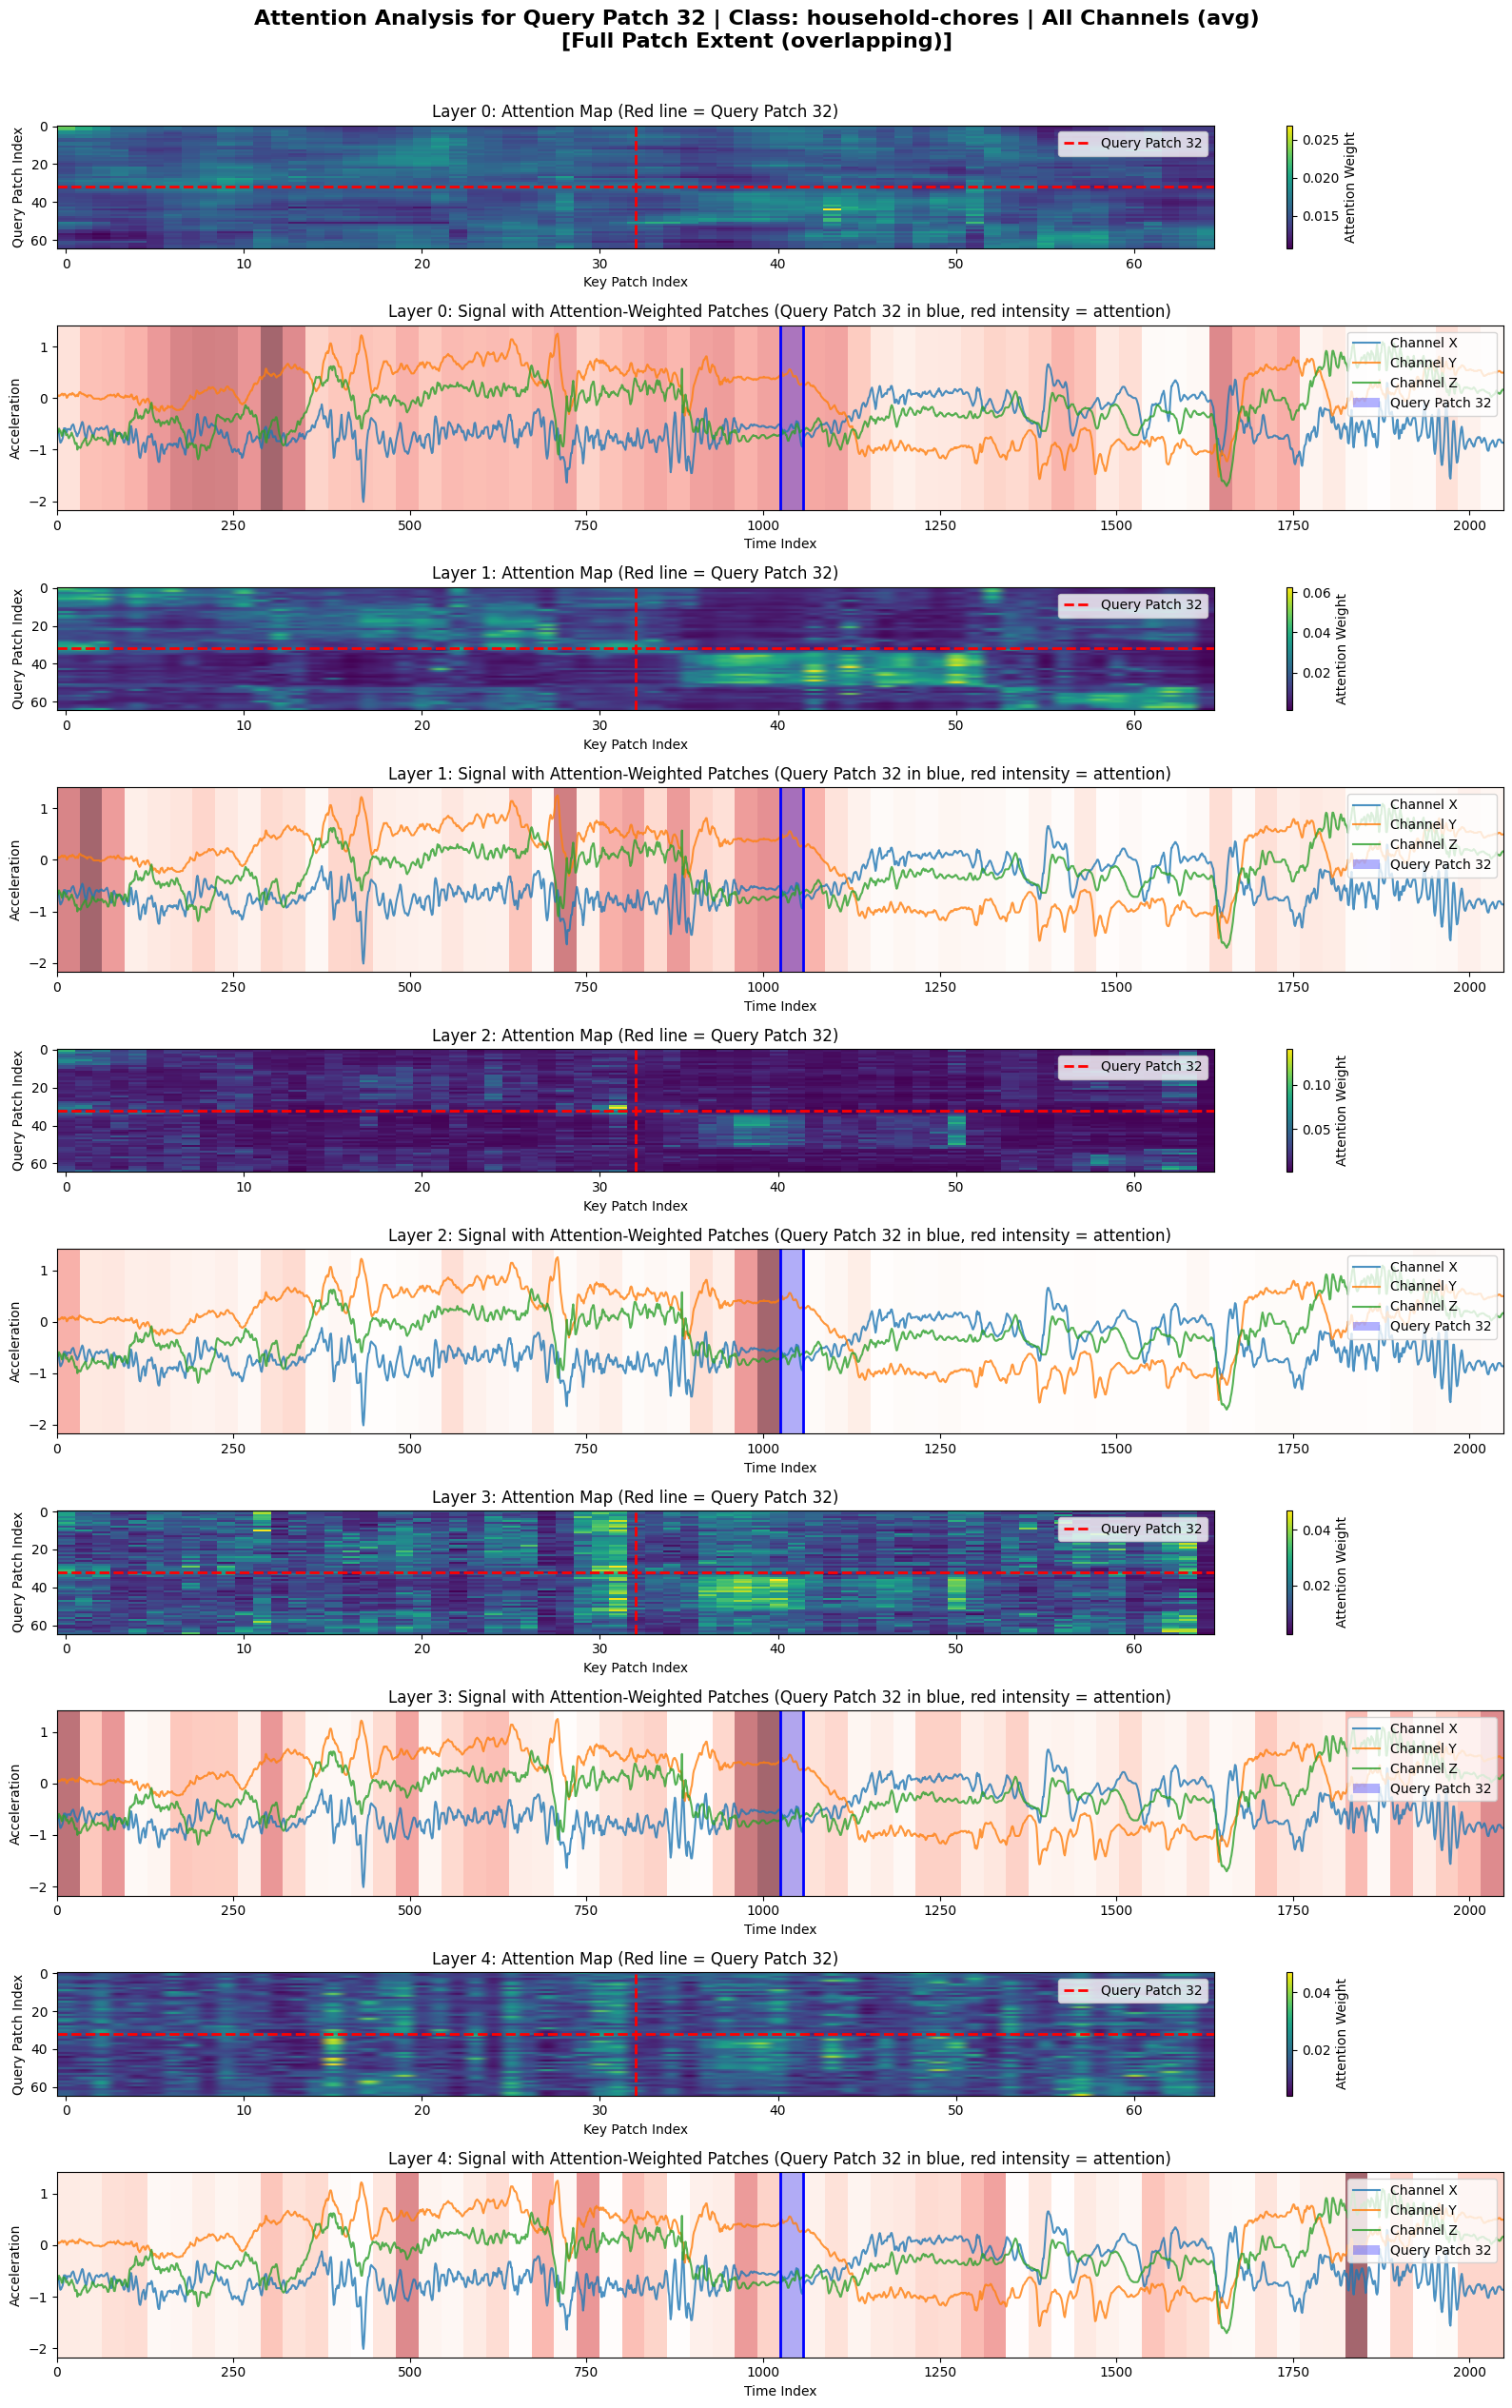


Top 5 attended patches per layer (Query Patch 32):

Layer 0:
  1. Patch 9 (time 288-320): 0.0187
  2. Patch 6 (time 192-224): 0.0178
  3. Patch 7 (time 224-256): 0.0178
  4. Patch 5 (time 160-192): 0.0176
  5. Patch 51 (time 1632-1664): 0.0174

Layer 1:
  1. Patch 1 (time 32-64): 0.0428
  2. Patch 22 (time 704-736): 0.0373
  3. Patch 0 (time 0-32): 0.0357
  4. Patch 31 (time 992-1024): 0.0330
  5. Patch 27 (time 864-896): 0.0310

Layer 2:
  1. Patch 31 (time 992-1024): 0.0810
  2. Patch 30 (time 960-992): 0.0579
  3. Patch 0 (time 0-32): 0.0505
  4. Patch 10 (time 320-352): 0.0340
  5. Patch 17 (time 544-576): 0.0320

Layer 3:
  1. Patch 31 (time 992-1024): 0.0339
  2. Patch 0 (time 0-32): 0.0318
  3. Patch 30 (time 960-992): 0.0305
  4. Patch 63 (time 2016-2048): 0.0278
  5. Patch 2 (time 64-96): 0.0260

Layer 4:
  1. Patch 57 (time 1824-1856): 0.0346
  2. Patch 15 (time 480-512): 0.0291
  3. Patch 23 (time 736-768): 0.0270
  4. Patch 30 (time 960-992): 0.0266
  5. Patch 41 (time 131

In [21]:
# =============================================
# TEST VISUALIZATION - Single Example, Single Patch
# =============================================

# Select a patch index to analyze (try middle of sequence)
SELECTED_PATCH_IDX = num_patches // 2  # Middle patch

print(f"Visualizing attention for:")
print(f"  Class: {test_label}")
print(f"  Query Patch Index: {SELECTED_PATCH_IDX} / {num_patches-1}")
print(f"  Number of Layers: {len(model.attention_maps)}")

# Visualize all layers
# Toggle use_stride_segments:
#   - False (default): Show full patch extent (overlapping regions)
#   - True: Show non-overlapping stride-sized segments (cleaner visualization)

visualize_all_layers_attention(
    test_example=test_example,
    attention_maps=model.attention_maps,
    patch_idx=SELECTED_PATCH_IDX,
    patch_length=patch_length,
    stride=stride,
    lookback_window=lookback_window,
    label=test_label,
    channel_idx=None,  # Average all channels (or 0=X, 1=Y, 2=Z)
    use_stride_segments=False  # Set to False for overlapping full patch view
)